In [81]:
import pylab
import pymoc
import xidplus
import numpy as np
%matplotlib inline
from astropy.io import fits
from astropy import wcs
from astropy.table import Table
import seaborn as sns

This notebook uses all the raw data from the XID+MIPS catalogue, maps, PSF and relevant MOCs to create XID+ prior object and relevant tiling scheme

## Read in MOCs
The selection functions required are the main MOC associated with the masterlist. As the prior for XID+ is based on IRAC detected sources coming from two different surveys at different depths (SERVS and SWIRE) I will split the XID+ run into two different runs. Here we use the SERVS depth.

In [82]:
Sel_func=pymoc.MOC()
Sel_func.read('../../dmu4/dmu4_sm_SPIRE-NEP/data/holes_SPIRE-NEP_irac1_O16_20190201_WARNING-MADE-WITH-Lockman-SWIRE-PARAMS.fits')
_MOC=pymoc.MOC()
_MOC.read('../../dmu0/dmu0_PanSTARRS1-3SS/data/PanSTARRS1-3SS_SPIRE-NEP_v2_MOC.fits')

In [4]:
Final=Sel_func.intersection(_MOC)
Final.write('./data/testMoc.fits', overwrite=True)

## Read in XID+MIPS catalogue

In [83]:
XID_MIPS=Table.read('../dmu26_XID+MIPS_SPIRE-NEP/data/dmu26_XID+MIPS_SPIRE-NEP_cat_20191107.fits')

In [84]:
XID_MIPS[0:10]

help_id,RA,Dec,F_MIPS_24,FErr_MIPS_24_u,FErr_MIPS_24_l,Bkg_MIPS_24,Sig_conf_MIPS_24,Rhat_MIPS_24,n_eff_MIPS_24,Pval_res_24,flag_mips_24
,degrees,degrees,muJy,muJy,muJy,MJy / sr,MJy / sr,,,,
bytes27,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,bool
HELP_J174025.417+684835.714,265.105902876941,68.8099204362451,28.077917,40.18007,15.761656,2.6469126,4.9711653e-06,0.9997422,1086.0,1.0,True
HELP_J174022.766+684839.353,265.094860056941,68.8109313862451,104.62864,118.209305,91.06474,2.6469126,4.9711653e-06,0.99973947,1325.0,0.0,False
HELP_J174045.700+684838.549,265.190415006941,68.8107079862451,791.2091,799.17896,783.36304,2.6553843,4.9953483e-06,nan,1137.0,1.0,True
HELP_J174107.472+684944.285,265.281135126941,68.8289680462451,0.6294035,1.5587283,0.18753357,2.6487827,5.188393e-06,nan,2000.0,0.996,True
HELP_J174107.090+684956.113,265.279540076941,68.8322535362451,0.7732246,1.8341007,0.2031018,2.6487827,5.188393e-06,nan,2000.0,0.633,True
HELP_J174106.372+684923.917,265.27654936694097,68.8233102362451,1.0806952,2.6539407,0.30152187,2.6487827,5.188393e-06,nan,2000.0,0.959,True
HELP_J174102.598+684909.321,265.260825846941,68.8192558362451,0.9249326,2.4398484,0.2234823,2.6487827,5.188393e-06,nan,2000.0,0.666,True
HELP_J174113.520+685022.720,265.306333326941,68.8396444362451,1.6002395,3.6738312,0.48916787,2.6487827,5.188393e-06,nan,2000.0,0.694,True


3.37847
2


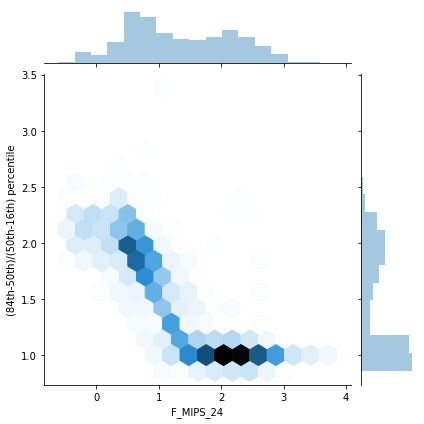

In [85]:
skew=(XID_MIPS['FErr_MIPS_24_u']-XID_MIPS['F_MIPS_24'])/(XID_MIPS['F_MIPS_24']-XID_MIPS['FErr_MIPS_24_l'])
skew.name='(84th-50th)/(50th-16th) percentile'
use = skew < 5 
n_use=skew>5
g=sns.jointplot(x=np.log10(XID_MIPS['F_MIPS_24'][use]),y=skew[use] ,kind='hex')
print(np.max(skew[use]))
print(len(skew[n_use]))


In [94]:
10**1.3

19.952623149688797

The uncertianties become Gaussian by $\sim 20 \mathrm{\mu Jy}$

In [91]:
good=XID_MIPS['F_MIPS_24']>20
print(len(good))

1213


In [92]:
good.sum()

562

## Read in Maps

In [63]:
pswfits='../../dmu19/dmu19_HELP-SPIRE-maps/data/SPIRE-NEP_SPIRE250_v1.0.fits'#SPIRE 250 map
pmwfits='../../dmu19/dmu19_HELP-SPIRE-maps/data/SPIRE-NEP_SPIRE350_v1.0.fits'#SPIRE 350 map
plwfits='../../dmu19/dmu19_HELP-SPIRE-maps/data/SPIRE-NEP_SPIRE500_v1.0.fits'#SPIRE 500 map

#output folder
output_folder='./data/'

In [74]:

#-----250-------------
hdulist = fits.open(pswfits)
im250phdu=hdulist[0].header
im250hdu=hdulist['IMAGE'].header

im250=hdulist['IMAGE'].data*1.0E3 #convert to mJy
nim250=hdulist['ERROR'].data*1.0E3 #convert to mJy
cov250=hdulist[4].data

w_250 = wcs.WCS(hdulist['IMAGE'].header)
pixsize250=3600.0*w_250.wcs.cdelt[1] #pixel size (in arcseconds)
hdulist.close()
#-----350-------------
hdulist = fits.open(pmwfits)
im350phdu=hdulist[0].header
im350hdu=hdulist['IMAGE'].header

im350=hdulist['IMAGE'].data*1.0E3 #convert to mJy
nim350=hdulist['ERROR'].data*1.0E3 #convert to mJy
cov350=hdulist[4].data
w_350 = wcs.WCS(hdulist['IMAGE'].header)
pixsize350=3600.0*w_350.wcs.cdelt[1] #pixel size (in arcseconds)
hdulist.close()
#-----500-------------
hdulist = fits.open(plwfits)
im500phdu=hdulist[0].header
im500hdu=hdulist['IMAGE'].header

im500=hdulist['IMAGE'].data*1.0E3 #convert to mJy
nim500=hdulist['ERROR'].data*1.0E3 #convert to mJy
cov500=hdulist[4].data
w_500 = wcs.WCS(hdulist['IMAGE'].header)
pixsize500=3600.0*w_500.wcs.cdelt[1] #pixel size (in arcseconds)
hdulist.close()

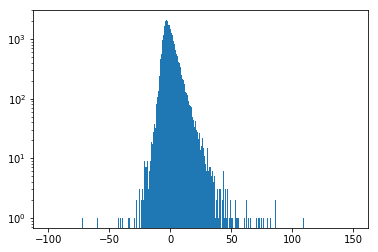

In [75]:
import matplotlib.pyplot as plt
plt.hist(im250.flatten(),bins=np.arange(-100.0,150.0,0.5));
plt.yscale('log')

In [11]:
## Set XID+ prior class

In [78]:
#---prior250--------
prior250=xidplus.prior(im250,nim250,im250phdu,im250hdu, moc=Final)#Initialise with map, uncertianty map, wcs info and primary header
prior250.prior_cat(XID_MIPS['RA'][good],XID_MIPS['Dec'][good],'dmu26_XID+MIPS_SPIRE-NEP_cat_20191107.fits',ID=XID_MIPS['help_id'][good])#Set input catalogue
prior250.prior_bkg(-5.0,5)#Set prior on background (assumes Gaussian pdf with mu and sigma)
#---prior350--------
prior350=xidplus.prior(im350,nim350,im350phdu,im350hdu, moc=Final)
prior350.prior_cat(XID_MIPS['RA'][good],XID_MIPS['Dec'][good],'dmu26_XID+MIPS_SPIRE-NEP_cat_20191107.fits',ID=XID_MIPS['help_id'][good])
prior350.prior_bkg(-5.0,5)

#---prior500--------
prior500=xidplus.prior(im500,nim500,im500phdu,im500hdu, moc=Final)
prior500.prior_cat(XID_MIPS['RA'][good],XID_MIPS['Dec'][good],'dmu26_XID+MIPS_SPIRE-NEP_cat_20191107.fits',ID=XID_MIPS['help_id'][good])
prior500.prior_bkg(-5.0,5)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]


In [79]:
#pixsize array (size of pixels in arcseconds)
pixsize=np.array([pixsize250,pixsize350,pixsize500])
#point response function for the three bands
prfsize=np.array([18.15,25.15,36.3])
#use Gaussian2DKernel to create prf (requires stddev rather than fwhm hence pfwhm/2.355)
from astropy.convolution import Gaussian2DKernel

##---------fit using Gaussian beam-----------------------
prf250=Gaussian2DKernel(prfsize[0]/2.355,x_size=101,y_size=101)
prf250.normalize(mode='peak')
prf350=Gaussian2DKernel(prfsize[1]/2.355,x_size=101,y_size=101)
prf350.normalize(mode='peak')
prf500=Gaussian2DKernel(prfsize[2]/2.355,x_size=101,y_size=101)
prf500.normalize(mode='peak')

pind250=np.arange(0,101,1)*1.0/pixsize[0] #get 250 scale in terms of pixel scale of map
pind350=np.arange(0,101,1)*1.0/pixsize[1] #get 350 scale in terms of pixel scale of map
pind500=np.arange(0,101,1)*1.0/pixsize[2] #get 500 scale in terms of pixel scale of map

prior250.set_prf(prf250.array,pind250,pind250)#requires psf as 2d grid, and x and y bins for grid (in pixel scale)
prior350.set_prf(prf350.array,pind350,pind350)
prior500.set_prf(prf500.array,pind500,pind500)

In [80]:
import pickle
#from moc, get healpix pixels at a given order
from xidplus import moc_routines
order=9
tiles=moc_routines.get_HEALPix_pixels(order,prior250.sra,prior250.sdec,unique=True)
order_large=6
tiles_large=moc_routines.get_HEALPix_pixels(order_large,prior250.sra,prior250.sdec,unique=True)
print('----- There are '+str(len(tiles))+' tiles required for input catalogue and '+str(len(tiles_large))+' large tiles')
output_folder='./data/'
outfile=output_folder+'Master_prior.pkl'
with open(outfile, 'wb') as f:
    pickle.dump({'priors':[prior250,prior350,prior500],'tiles':tiles,'order':order,'version':xidplus.io.git_version()},f)
outfile=output_folder+'Tiles.pkl'
with open(outfile, 'wb') as f:
    pickle.dump({'tiles':tiles,'order':order,'tiles_large':tiles_large,'order_large':order_large,'version':xidplus.io.git_version()},f)
raise SystemExit()

----- There are 13 tiles required for input catalogue and 2 large tiles


SystemExit: 